# Introduction

Principal Component Analysis (PCA) is a linear algebra operation that can be performed on a set of data to reduce dimensionality to a subspace of the initial set, removing dimensions who’s contribution to the distance between individual data points is minimal. Additionally, sports prediction is a popular application for machine learning models. The accuracy of these models could be improved by applying a pre-processing effect such as PCA while also providing insights to team members or coaches as to which stats are the most important for driving success.

The purpose of this project is to assess the effect of PCA on the accuracy of a sports prediction model and provide an explanation for why particular stats were eliminated. Given a dataset of calculated performance statistics (such as ADJOE; adjusted offensive efficiency) for division 1 college basketball teams ranging from 2013 to 2023, we will use an 80-20 train-test split, evenly made up of randomly selected teams from each year. Using this data, we will train two identical models, recording performance at fixed epoch intervals. One model will be trained with a PCA-processed train set and the other (the control model) with the raw train set. PCA will use an accumulative variance threshold of 95%, a value common to the research we followed. This value will maintain the majority of the data while eliminating insignificant portions.

#### Hypothesis

Our hypothesis is that PCA will improve prediction accuracy at lower epochs by eliminating less important stats but begin negatively impacting performance past a point because of the eliminated data.

# Loading Data

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from kagglehub import dataset_download
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\Users\ryan9\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = dataset_download("andrewsundberg/college-basketball-dataset")
df = pd.read_csv(path + '\\cbb.csv')

In [38]:
X = pd.get_dummies(df[['EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D']])
y = df['W'] / df['G']

#### Output data

The models will predict winrate (# wins / # games) based on the following stats:

'EFG_O', 'EFG_D', 'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D'

Below is a graph of the winrate distribution.

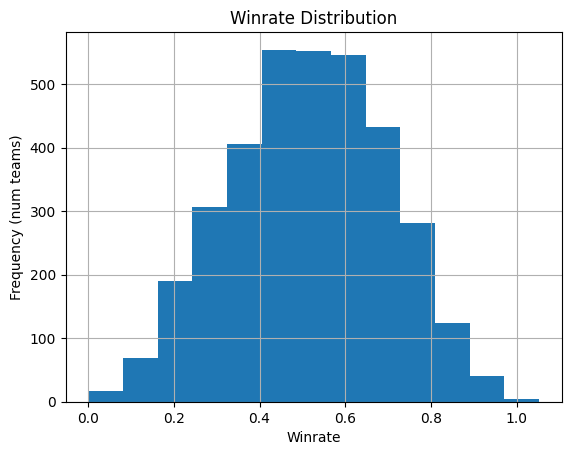

In [40]:
y.hist(bins = 13)
plt.xlabel('Winrate')
plt.ylabel('Frequency (num teams)')
plt.title('Winrate Distribution')
plt.show()

# PCA (Principle Component Analysis)

Principal component analysis is conducted using the scikit learn decomposition library.

This will create a lower-dimensional basis for the data that maximizes the normalized variance, then project the data to that new basis.

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

In [9]:
k = 3
pca = PCA(n_components=k) 
principal_components = pca.fit_transform(data_scaled)

In [10]:
X_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(k)])

We now have our completed `X_pca` input data. 

# The Models

In [11]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=.2)

### Scale Control Data

In [13]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

### Scale PCA Data

In [14]:
scaler_X_pca = MinMaxScaler()
scaler_y_pca = MinMaxScaler()
X_pca_train_scaled = scaler_X.fit_transform(X_pca_train)
y_pca_train_scaled = scaler_y.fit_transform(y_pca_train.values.reshape(-1, 1))

X_pca_test_scaled = scaler_X.transform(X_pca_test)
y_pca_test_scaled = scaler_y.transform(y_pca_test.values.reshape(-1, 1))

#### Control Model

In [15]:
control_model = Sequential()
control_model.add(Input(shape = (len(X_train.columns),)))
control_model.add(Dense(units=8, activation='relu'))
control_model.add(Dense(units=16, activation='relu'))
control_model.add(Dense(units=1, activation='sigmoid'))

control_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

In [16]:
control_history = control_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0352 - mae: 0.1552
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - mae: 0.1425
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mae: 0.1175
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - mae: 0.0878
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mae: 0.0732
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mae: 0.0703
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - mae: 0.0651
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0630
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mae: 0.0618
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - mae: 0.0604
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mae: 0.0590
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0596
Epoch 13/100
89/89 ━━━━━━━━━━━━━━━━━━

#### PCA Model

In [17]:
pca_model = Sequential()
pca_model.add(Input(shape = (len(X_pca_train.columns),)))
pca_model.add(Dense(units=8, activation='relu'))
pca_model.add(Dense(units=16, activation='relu'))
pca_model.add(Dense(units=1, activation='sigmoid'))

pca_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

In [18]:
pca_history = pca_model.fit(X_pca_train_scaled, y_pca_train_scaled, epochs=100, batch_size=32)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0291 - mae: 0.1396
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mae: 0.1192
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - mae: 0.0918
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mae: 0.0733
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.0746
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - mae: 0.0742
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mae: 0.0722
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mae: 0.0722
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0755
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mae: 0.0722
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - mae: 0.0718
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.0713
Epoch 13/100
89/89 ━━━━━━━━━━━━━━━━━━

# Results: Assess Model Performance

In [19]:
Y_hat_control = control_model.predict(X_test_scaled)
Y_hat_pca = pca_model.predict(X_pca_test_scaled)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [20]:
control_error = mean_absolute_error(y_test_scaled, Y_hat_control)
pca_error = mean_absolute_error(y_pca_test_scaled, Y_hat_pca)

print("Control Error: " + str(control_error))
print("PCA Error: " + str(pca_error))

Control Error: 0.06217406480075107
PCA Error: 0.07080736980240654


# Conclusion & Results Analysis

During training, at low epochs (1-5), the PCA model outperforms the control model, however this relationship is quickly flipped (F3) as the PCA model plateaus at roughly 0.009 loss after only a handful of epochs. The control model, on the other hand, finds a minumum after roughly 10 epochs, settling at 0.006 training loss, much lower than the PCA model (F2). The performance on the test data reflect this, where the control error is roughly 0.062 and the PCA error is 0.071.

This behavior coincides with our hypothesis that initially PCA would improve performance of the model but begin to fall short relative to the control model, which ultimately has more access to data. However, the rate at which PCA was eclipsed was surprising. With that in mind, it is safe to say that PCA is not a good fit for this dataset as it does not provide a significant enough advantage in training speed to warrant the eventual loss of accuracy.

The reason PCA is not a good fit is likely due to two main factors:

First, the dimensionality of the original dataset is 12, meaning that any reduction in the complexity of the space by PCA is minimal. During training, this meant that the PCA model was given only a slight advantage relative to the control model in early epochs and was quickly starved for more data. 

Second, the dataset is not continuous. Rather than being 'readings' taken at intervals during basketball games, the dataset used is sparse, preprocessed, categorical data that does not take advantage of how PCA can identify nuanced, linear relationships between data columns. This further disadvantages the PCA model.

In the future, applying PCA to more dense, high dimensional data that is continuous. Within the scope of basketball, this could be individual sensor data on athletes during a game, predicting the eventual outcome. This could allow coaches to focus more specifically on optimizing physical parameters of athletes. PCA would be a better fit for this sort of dataset.

In [25]:
train_loss_control = control_history.history['loss']
train_loss_pca = pca_history.history['loss']
epochs = range(1, len(train_loss_control) + 1)

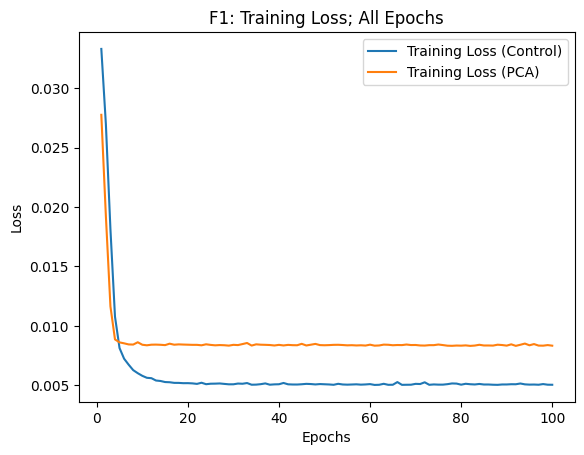

In [37]:
plt.plot(epochs, train_loss_control, label='Training Loss (Control)')
plt.plot(epochs, train_loss_pca, label='Training Loss (PCA)')
plt.xlabel('Epochs') 
plt.ylabel('Loss')  
plt.title('F1: Training Loss; All Epochs')
plt.legend()
plt.show()

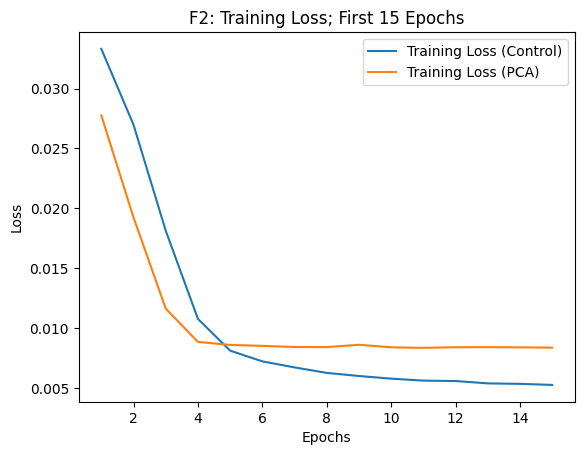

In [36]:
plt.plot(epochs[:15], train_loss_control[:15], label='Training Loss (Control)')
plt.plot(epochs[:15], train_loss_pca[:15], label='Training Loss (PCA)')
plt.xlabel('Epochs')  
plt.ylabel('Loss')   
plt.title('F2: Training Loss; First 15 Epochs')
plt.legend()
plt.show()

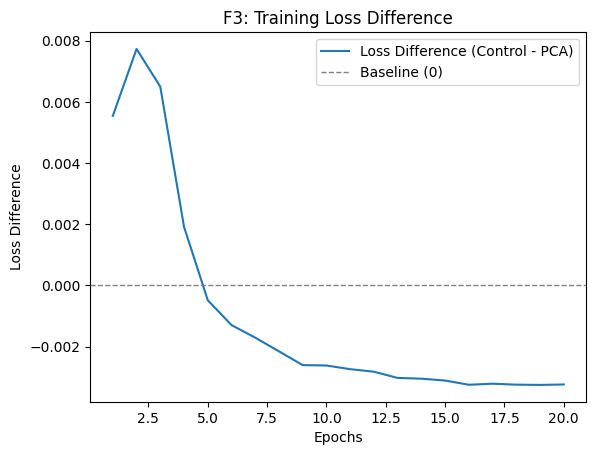

In [35]:
loss_difference = [c - p for c, p in zip(train_loss_control, train_loss_pca)]

plt.plot(epochs[:20], loss_difference[:20], label='Loss Difference (Control - PCA)')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Baseline (0)')
plt.title('F3: Training Loss Difference')
plt.legend()
plt.show()


In [30]:
control_model.save('control_model.keras')
pca_model.save('pca_model.keras')